## Introduction

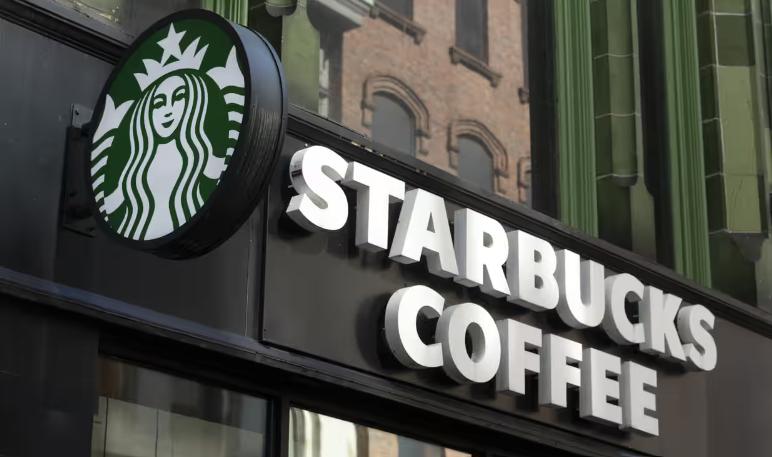


Welcome to a comprehensive Kaggle notebook that delves into the world of data analysis and natural language processing (NLP) applied to the Starbucks dataset reviews. In this exploration, we will embark on a journey through the rich collection of Starbucks customer feedback, aiming to uncover valuable insights hidden within the text data. Through the lens of exploratory data analysis (EDA) and NLP techniques, we'll shed light on customer sentiments, trends, and patterns, offering a nuanced perspective on Starbucks' customer experience. So, let's dive right in and discover the story these reviews have to tell.





If you are not familiar with text cleaning data here are the steps that we are going to follow :

* LowerCase
* Tokenize
* Remove punctuation
* Remove stopwords
* Lemmatizing

After We are going to Vectorize our data into a set of numbers to make it possible for the Machine Learning Models to learn from it because ML models only proccess numerical features :

* Vectorizing (TFID VECTORIZER)

## Imports

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import emoji
import spacy
nlp = spacy.load('en_core_web_sm')


import nltk
import string
from nltk.tokenize import word_tokenize
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB


from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.layers import GlobalMaxPooling1D,Embedding,Dense, LSTM

from sklearn.metrics import accuracy_score

## Getting Data

In [2]:
data = pd.read_csv("/kaggle/input/starbucks-reviews-dataset/reviews_data.csv")
data.head()

,name,location,Date,Rating,Review,Image_Links
0,Helen,"Wichita Falls, TX","Reviewed Sept. 13, 2023",5.0,Amber and LaDonna at the Starbucks on Southwes...,['No Images']
1,Courtney,"Apopka, FL","Reviewed July 16, 2023",5.0,** at the Starbucks by the fire station on 436...,['No Images']
2,Daynelle,"Cranberry Twp, PA","Reviewed July 5, 2023",5.0,I just wanted to go out of my way to recognize...,['https://media.consumeraffairs.com/files/cach...
3,Taylor,"Seattle, WA","Reviewed May 26, 2023",5.0,Me and my friend were at Starbucks and my card...,['No Images']
4,Tenessa,"Gresham, OR","Reviewed Jan. 22, 2023",5.0,I’m on this kick of drinking 5 cups of warm wa...,['https://media.consumeraffairs.com/files/cach...


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         850 non-null    object 
 1   location     850 non-null    object 
 2   Date         850 non-null    object 
 3   Rating       705 non-null    float64
 4   Review       850 non-null    object 
 5   Image_Links  850 non-null    object 
dtypes: float64(1), object(5)
memory usage: 40.0+ KB


In [4]:
data.isnull().sum()

name             0
location         0
Date             0
Rating         145
Review           0
Image_Links      0
dtype: int64

<Axes: >

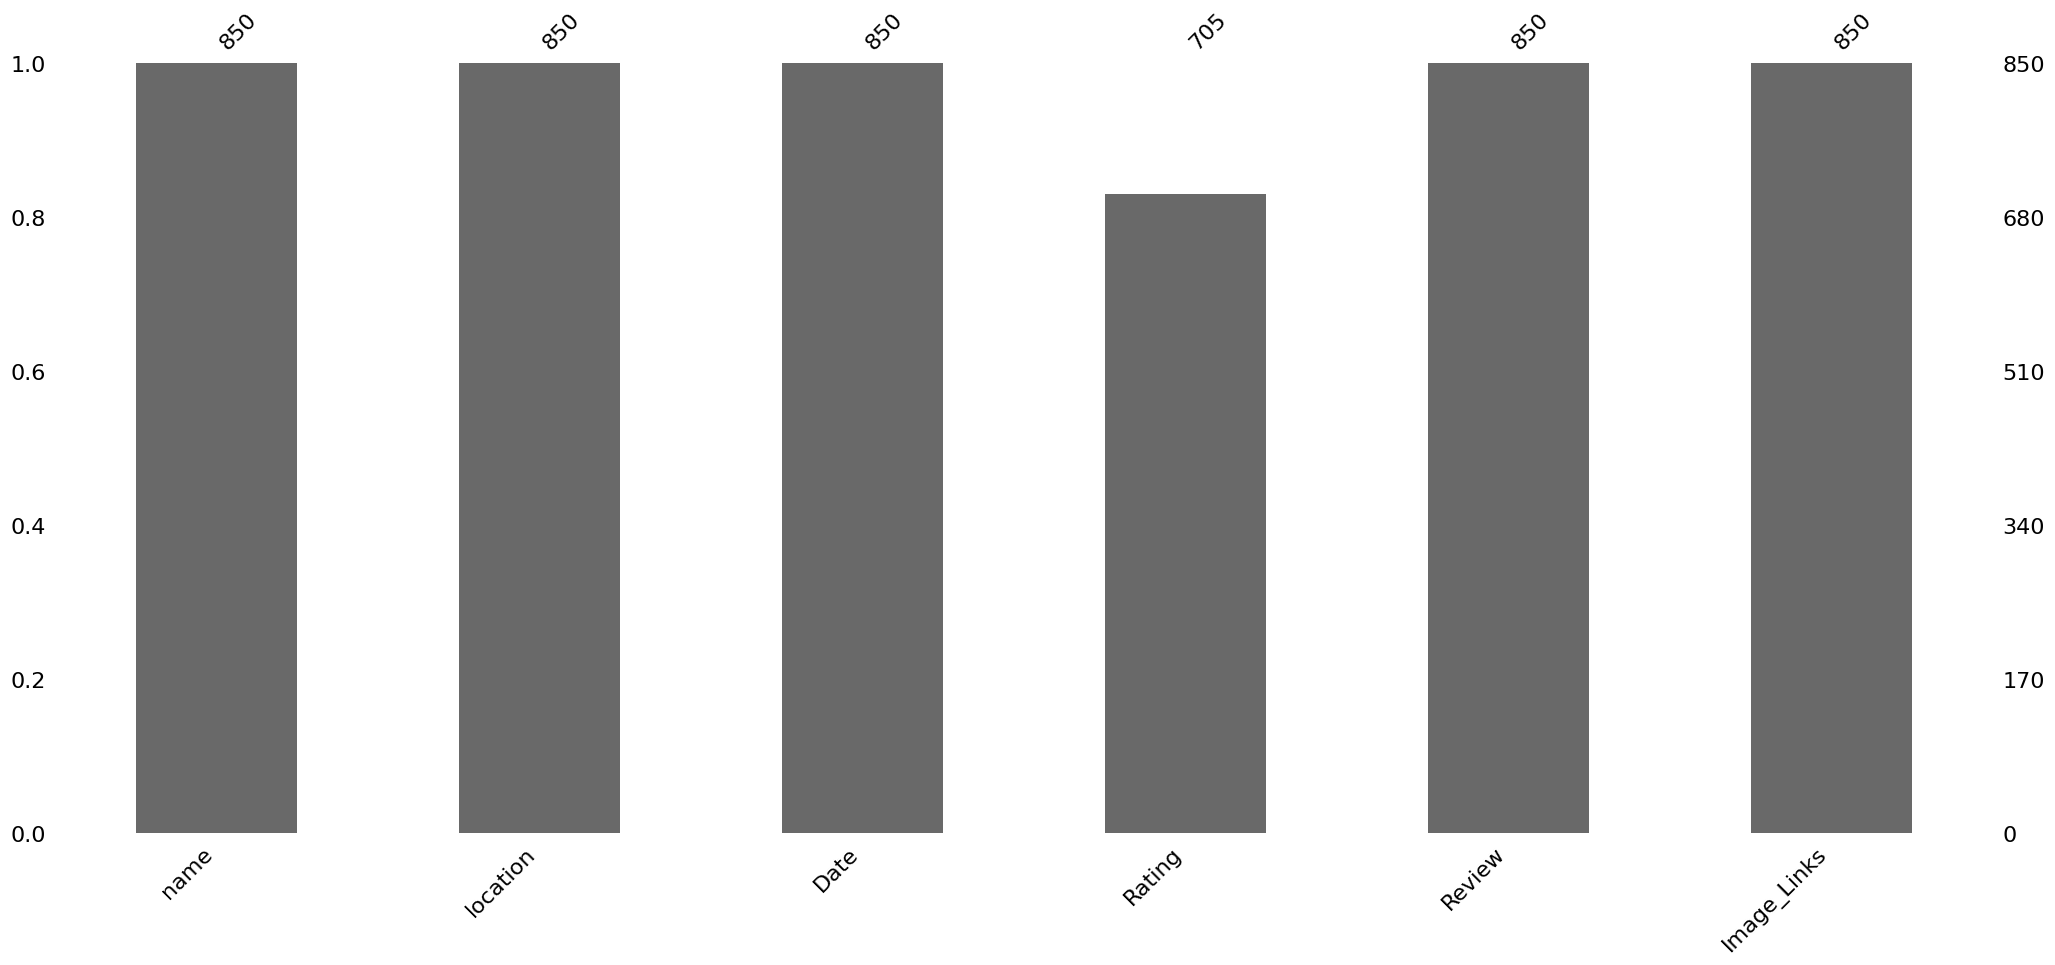

In [5]:
msno.bar(data)

We can understand that our dataset contains 850 observations that contains 5 features with no missing values and 1 target **Ratings** with 145 missing values

In [6]:
data.dropna(inplace=True)
data.drop(columns=['Image_Links'],inplace=True)

## EDA

### Rating

First let's start by having a look at our target **Ratings** to have an idea about what we are going to work with

<Axes: xlabel='Rating', ylabel='count'>

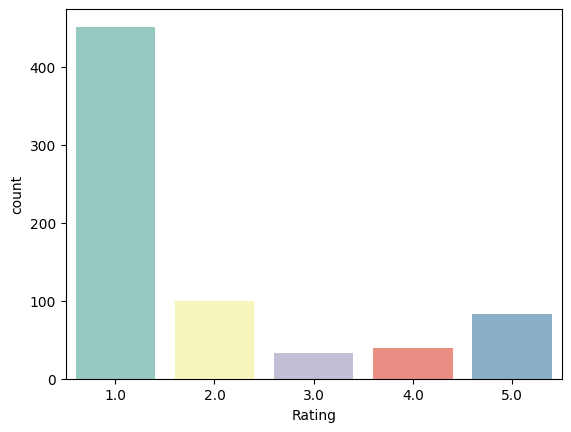

In [7]:
sns.countplot(x="Rating",data=data, palette="Set3")

It's clear that our data is imbalanced in which the majorety of review tends to be negative , this indicates that the company must review and improve its customer service by identifing and investigating problem areas

For Now we are going to split our data into 3 catagories : Positive , Negative and Neutral in which
* Neutral : 0
* Positive : 1
* Negative : 2

This helps the model classification and it's because we are intressted in fiding wherethere a customer is satisfied with the service or not!

In [8]:
data["Rating"]=data["Rating"].replace([1,2],2)
data["Rating"]=data["Rating"].replace(3,0)
data["Rating"]=data["Rating"].replace([4,5],1)
data = data.dropna(axis = 0, how ='any')
data["Rating"]=data["Rating"].astype(int)

In [9]:
data["Rating"].value_counts()

Rating
2    550
1    122
0     33
Name: count, dtype: int64

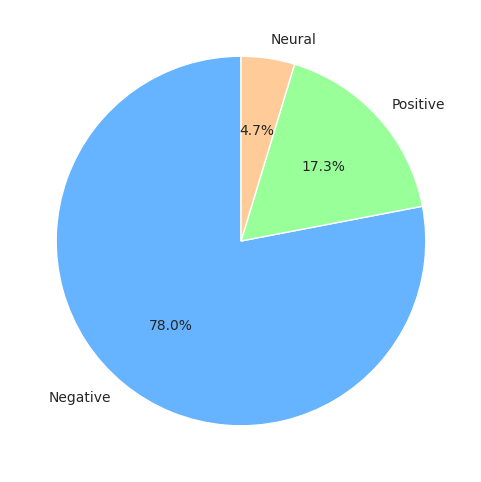

In [10]:
plt.figure(figsize=(6, 6))
sns.set_style("whitegrid")
plt.pie(data["Rating"].value_counts(),labels=["Negative","Positive","Neural"], autopct='%1.1f%%',colors=['#66b3ff', '#99ff99', '#ffcc99'] , startangle=90);

### Location

In [11]:
data["location"]=data["location"].str.split(",").str[1]

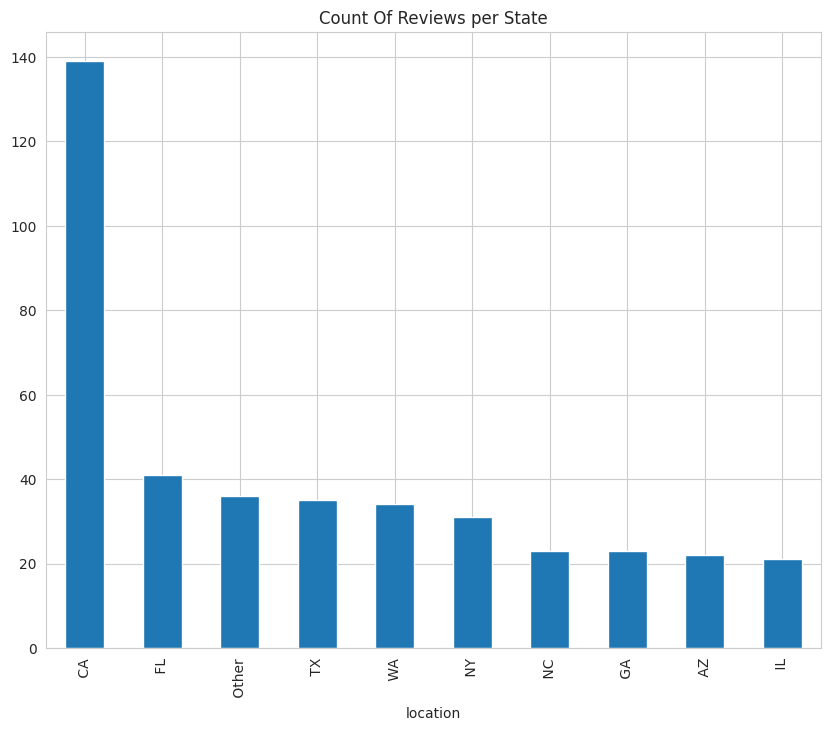

In [12]:
plt.figure(figsize=(10,8))
sns.set_style("whitegrid")
data["location"].value_counts().sort_values(ascending= False).head(10).plot.bar()
plt.title("Count Of Reviews per State");

Its clear that most review originates from California CA but this doesn't give us a prespective about the relation between locations and Ratings we need to see if there is any influence between locations and Votes

### Location/Ratings

In [13]:
df = data[["location","Rating"]]
df["Negative"] = df[df["Rating"]==2]["Rating"]
df["Positive"] = df[df["Rating"]==1]["Rating"]
df["Neutral"] = df[df["Rating"]==0]["Rating"]
df.drop("Rating",axis=1,inplace=True)
df=df.groupby("location").count().sort_values(ascending= False,by='Negative').head(9)

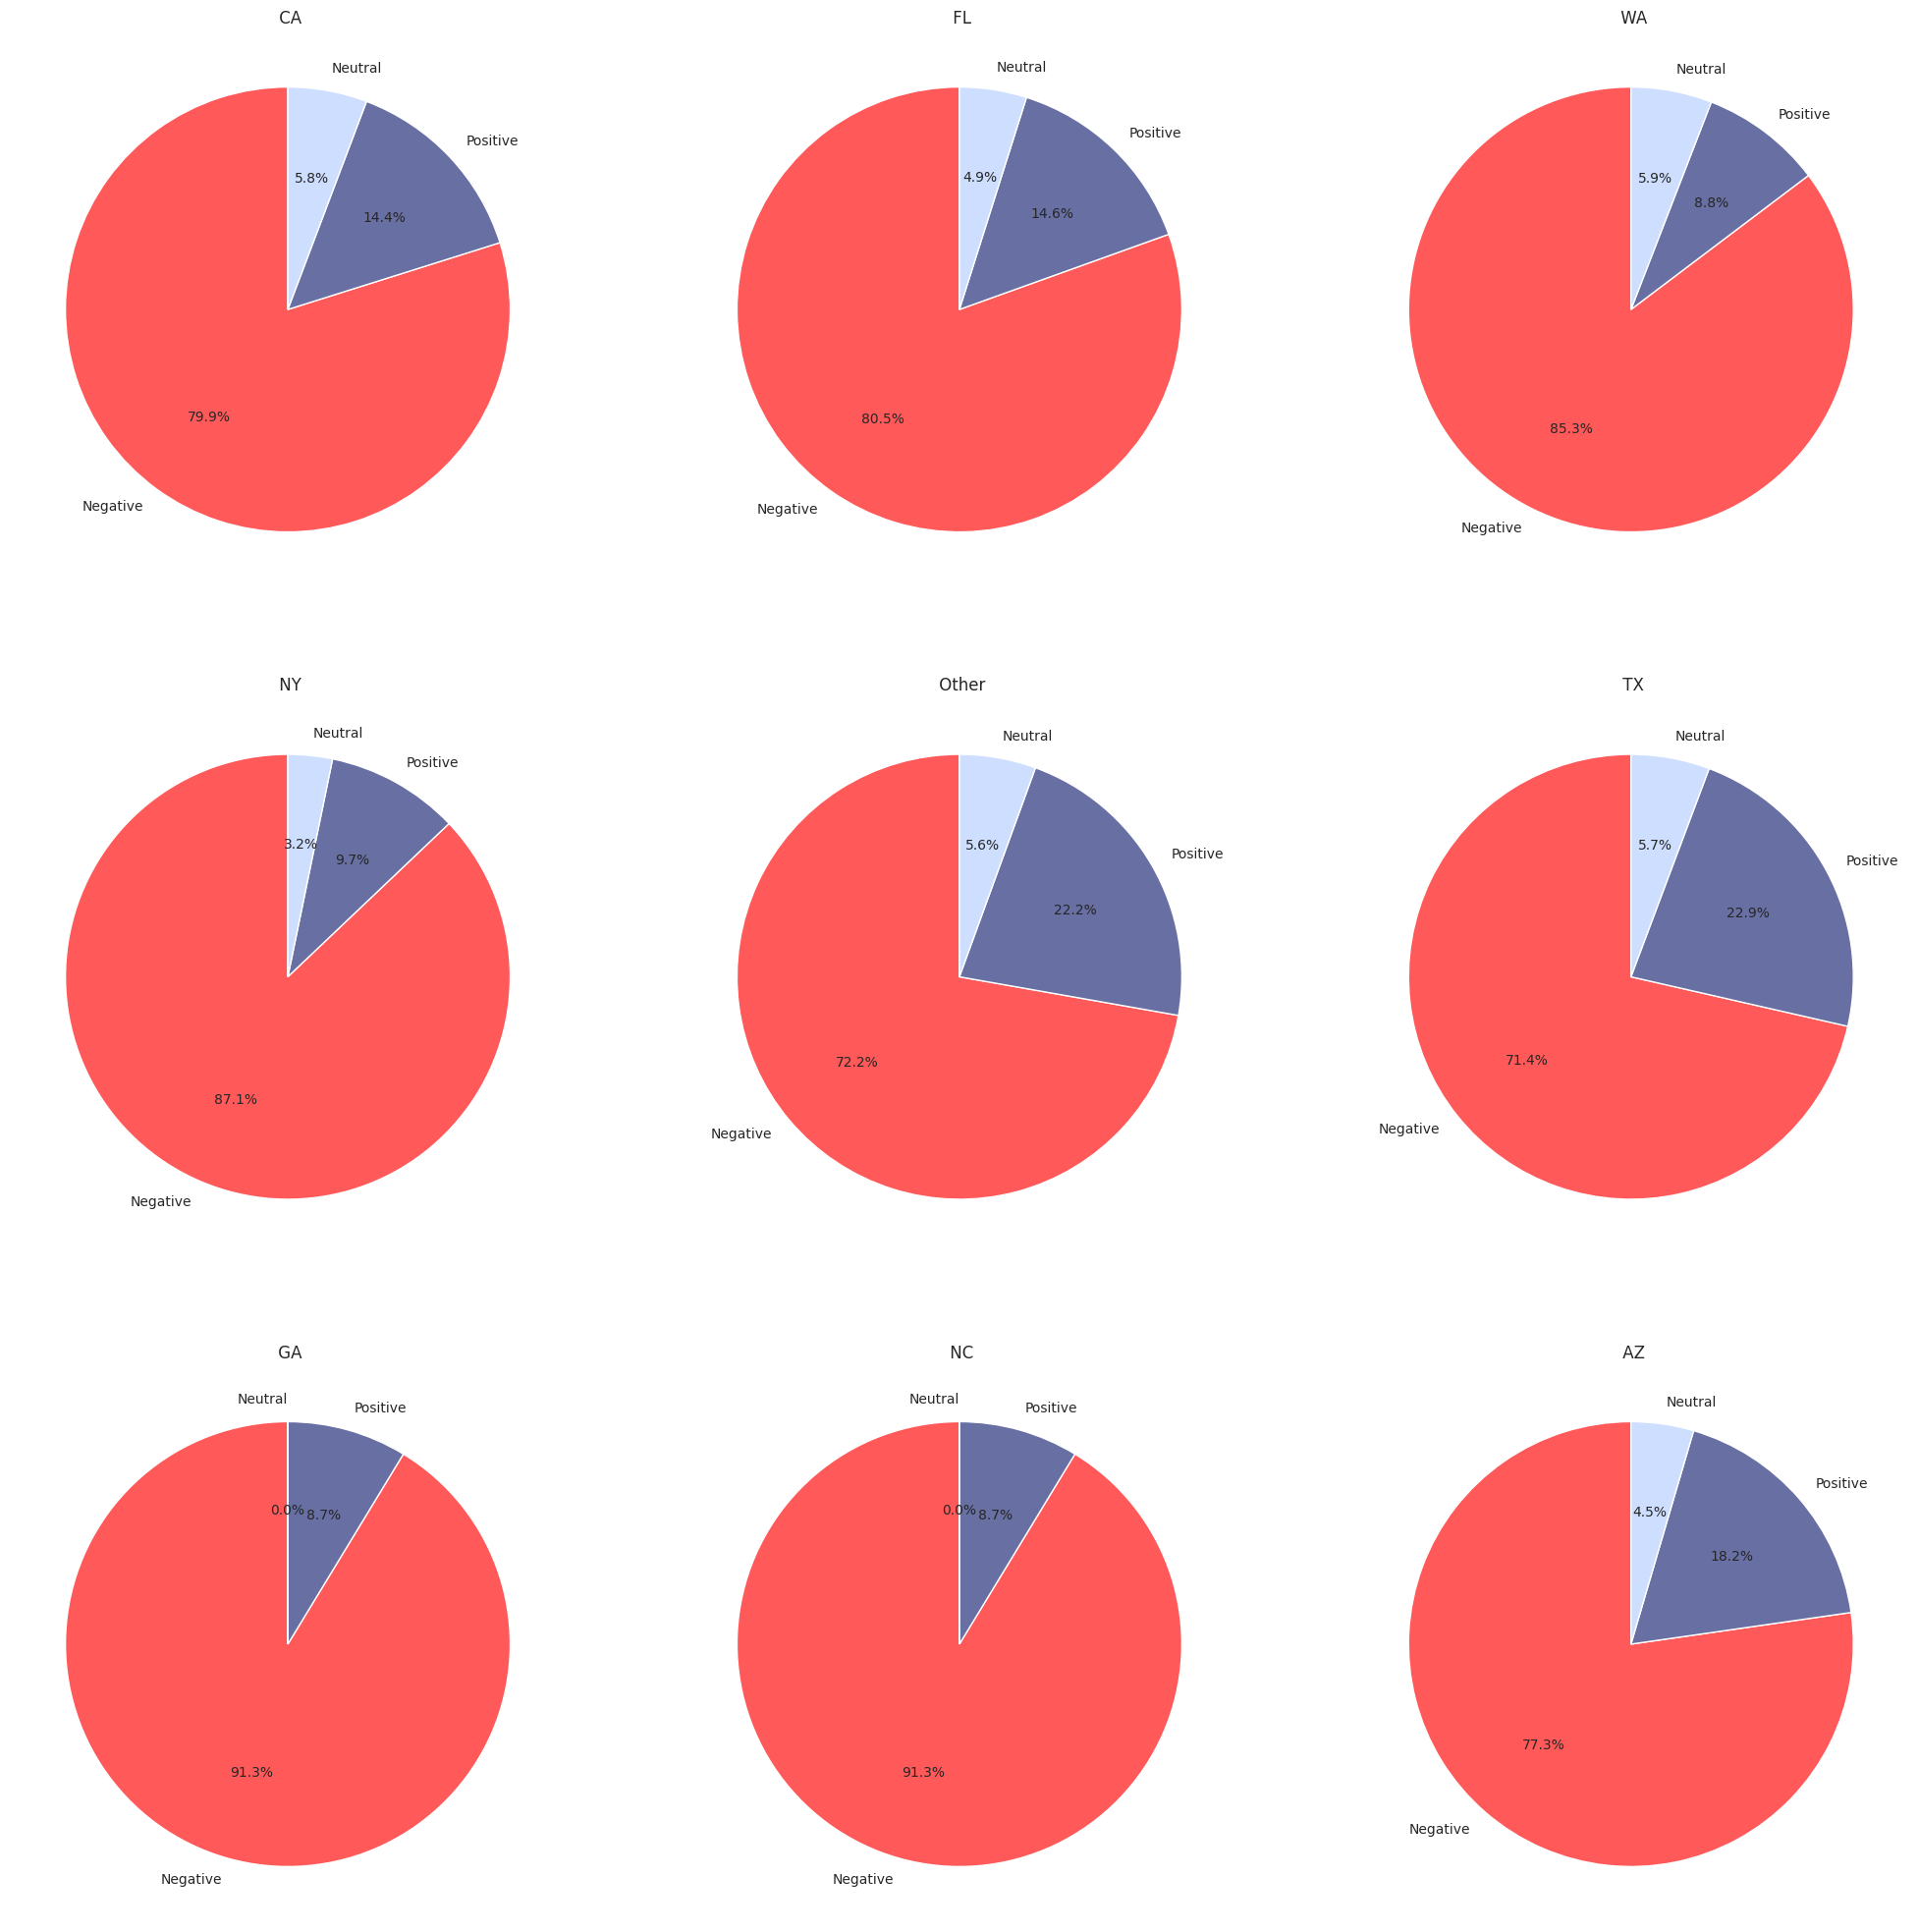

In [14]:
fig = plt.figure(figsize = (25, 25))
i=1
features = df.index
for x in features:
    plt.subplot(3, 3, i)
    ax=plt.pie(df.loc[x], labels=df.columns, autopct='%1.1f%%', startangle=90,
        colors=['#FF5959', '#676FA3','#CDDEFF'])
    plt.title(str(x), loc='center')
    i+=1
plt.show()

It looks like all the popular locations tend to have a negative review this might be an alarming information to set a plan for improvement

### Name

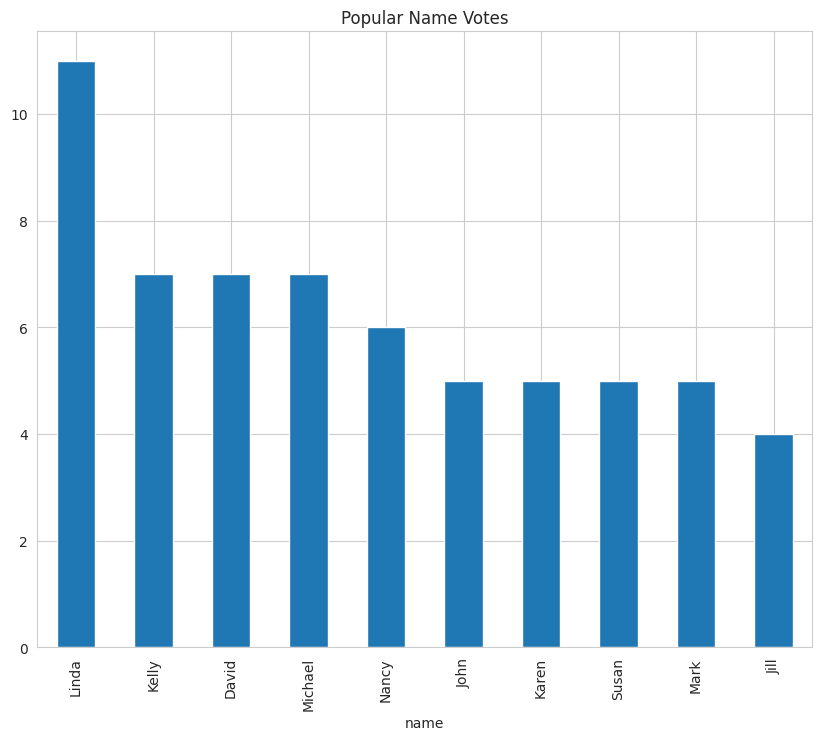

In [15]:
plt.figure(figsize=(10,8))
sns.set_style("whitegrid")
data["name"].value_counts().sort_values(ascending= False).head(10).plot.bar()
plt.title("Popular Name Votes");

It looks like the Name Linda tend to have the biggest number of votes

### Name/Rating

In [16]:
df = data[["name","Rating"]]
df["Negative"] = df[df["Rating"]==2]["Rating"]
df["Positive"] = df[df["Rating"]==1]["Rating"]
df["Neutral"] = df[df["Rating"]==0]["Rating"]
df.drop("Rating",axis=1,inplace=True)
df=df.groupby("name").count().sort_values(ascending= False,by='Negative').head(9)

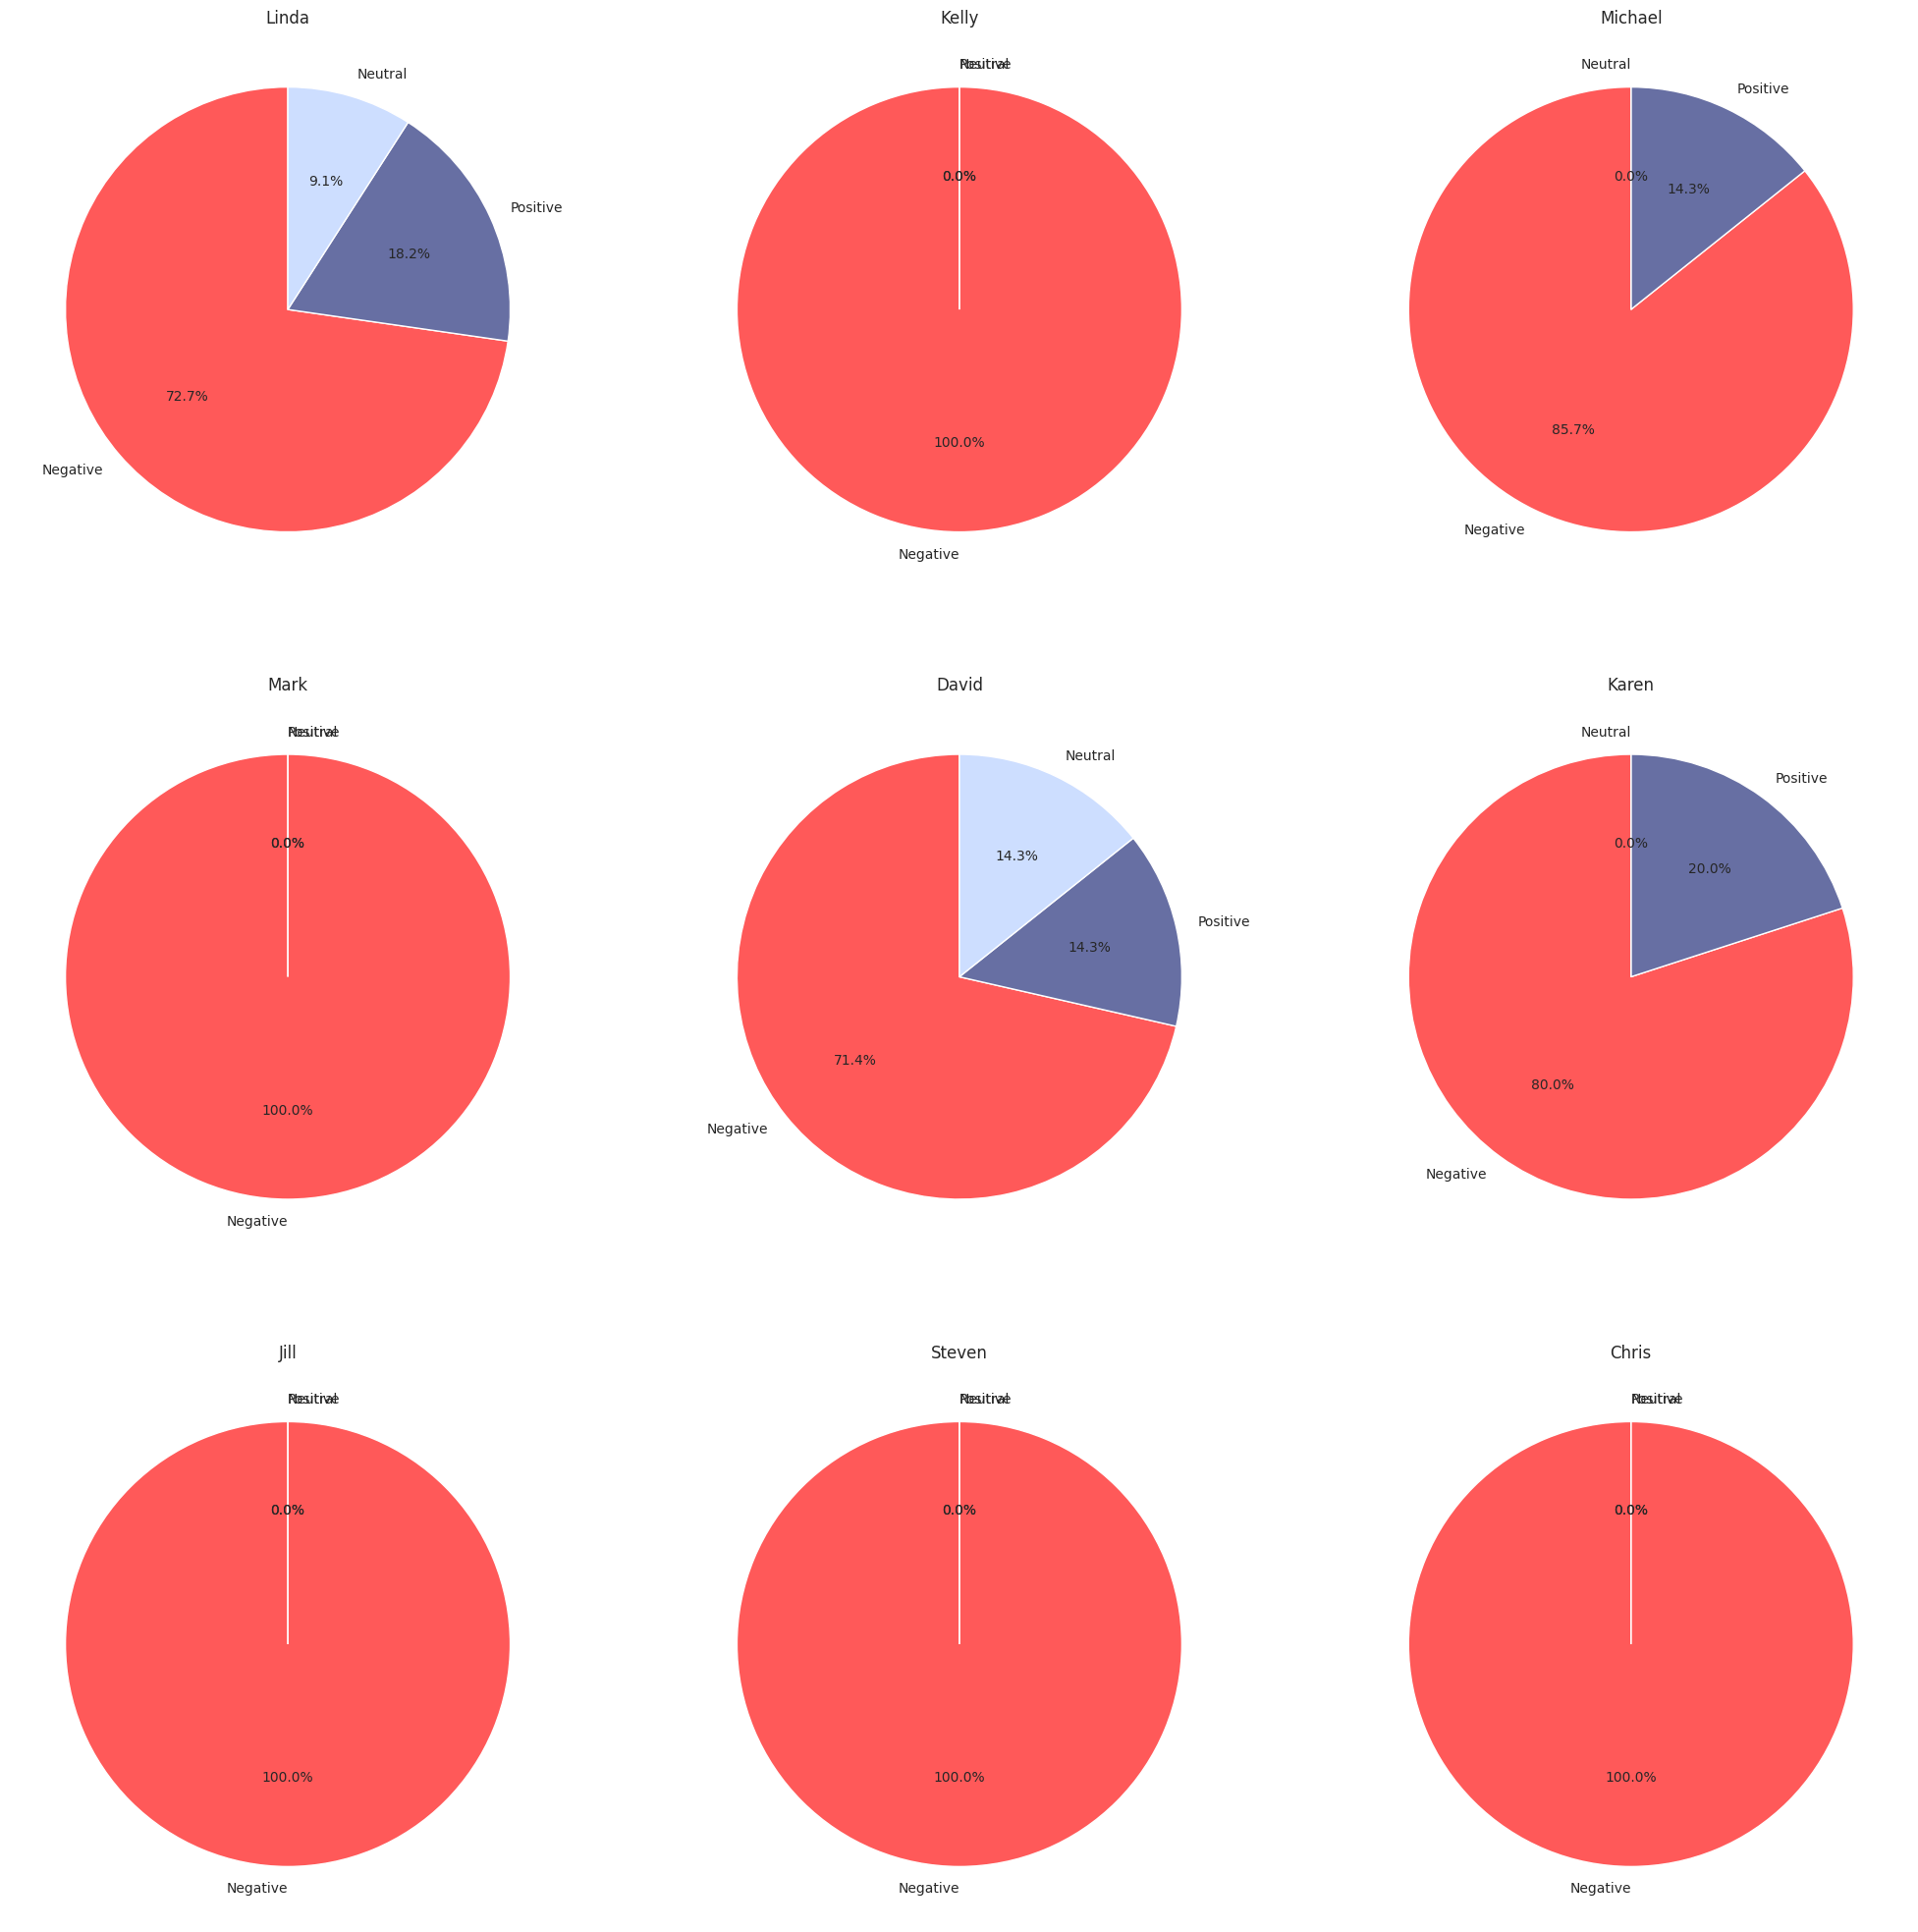

In [17]:
fig = plt.figure(figsize = (25, 25))
i=1
features = df.index
for x in features:
    plt.subplot(3, 3, i)
    ax=plt.pie(df.loc[x], labels=df.columns, autopct='%1.1f%%', startangle=90,
        colors=['#FF5959', '#676FA3','#CDDEFF'])
    plt.title(str(x), loc='center')
    i+=1
plt.show()

We can notice that most of the popular name have a 100% Negative Votes 

### Date

We are going to split the Data Column into 3 : Days of the week, Months and Years

In [18]:
data['Date'] = data['Date'].str.replace("Reviewed", "", case=False, regex=False)
data = data.astype({'Date': 'datetime64[ns]'})
data['Month'] = data['Date'].dt.month
data['Year'] = data['Date'].dt.year
data['DayOfWeek'] = data['Date'].dt.dayofweek

#### Days of the week

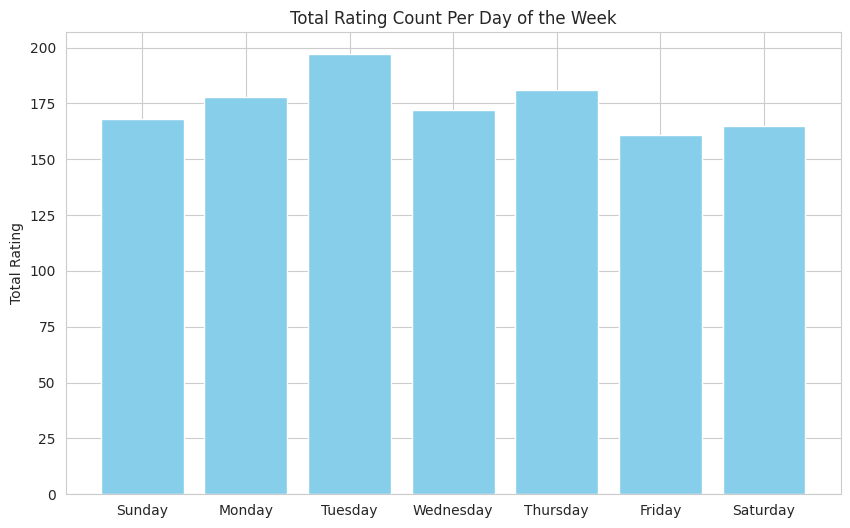

In [19]:
day_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
df = data.groupby(['DayOfWeek'])['Rating'].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.bar(df['DayOfWeek'], df['Rating'], color='skyblue')
plt.ylabel('Total Rating')
plt.title('Total Rating Count Per Day of the Week')
plt.xticks(df['DayOfWeek'], labels=day_order);

Its looks like the Submission of Ratings is nearly balanced with a small peak in Tuesday

#### Months

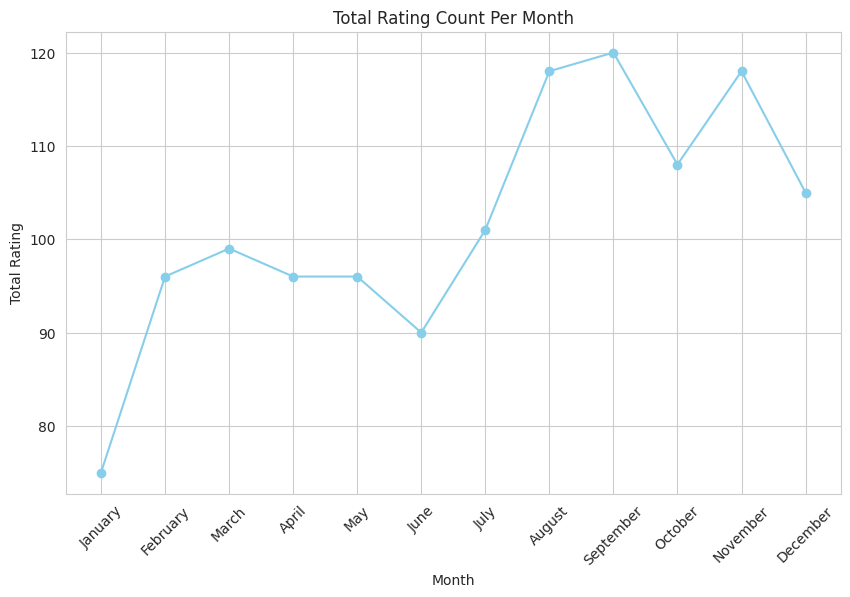

In [20]:
df = data.groupby(['Month'])['Rating'].sum().reset_index()
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

plt.figure(figsize=(10, 6))
plt.plot(df['Month'], df['Rating'], marker='o', color='skyblue', linestyle='-')
plt.xlabel('Month')
plt.ylabel('Total Rating')
plt.title('Total Rating Count Per Month')

plt.xticks(df['Month'], labels=month_order,rotation=45)
plt.grid(True)
plt.show()

#### Year

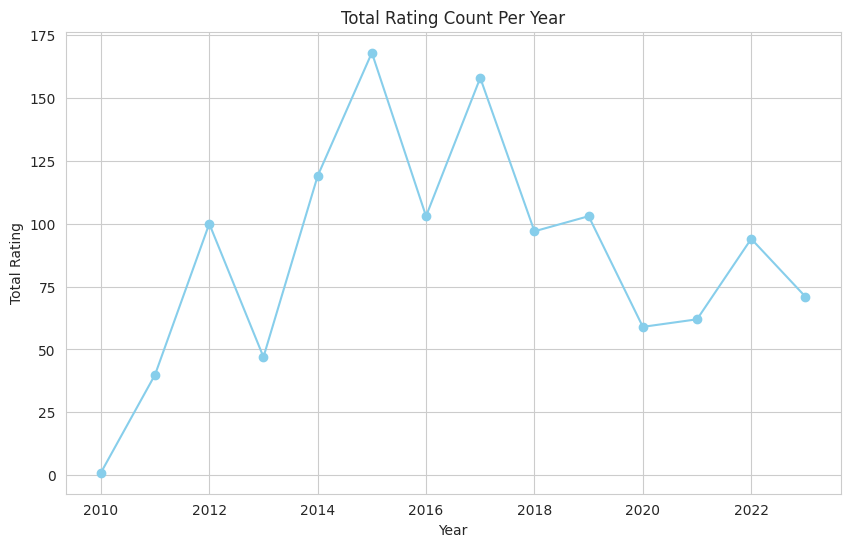

In [21]:
df = data.groupby(['Year'])['Rating'].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(df['Year'], df['Rating'], marker='o', color='skyblue', linestyle='-')
plt.xlabel('Year')
plt.ylabel('Total Rating')
plt.title('Total Rating Count Per Year')
plt.grid(True)
plt.show()

We can notice that there is a peak in 2015 and 2017 of Rating count per year, But its true that this chart give us the variations of Rating Thoughout the year but we can't see the influence of years on Ratings

#### Day/Rating

In [22]:
df = data[["DayOfWeek","Rating"]]
df["Negative"] = df[df["Rating"]==2]["Rating"]
df["Positive"] = df[df["Rating"]==1]["Rating"]
df["Neutral"] = df[df["Rating"]==0]["Rating"]
df.drop("Rating",axis=1,inplace=True)
df=df.groupby("DayOfWeek").count()

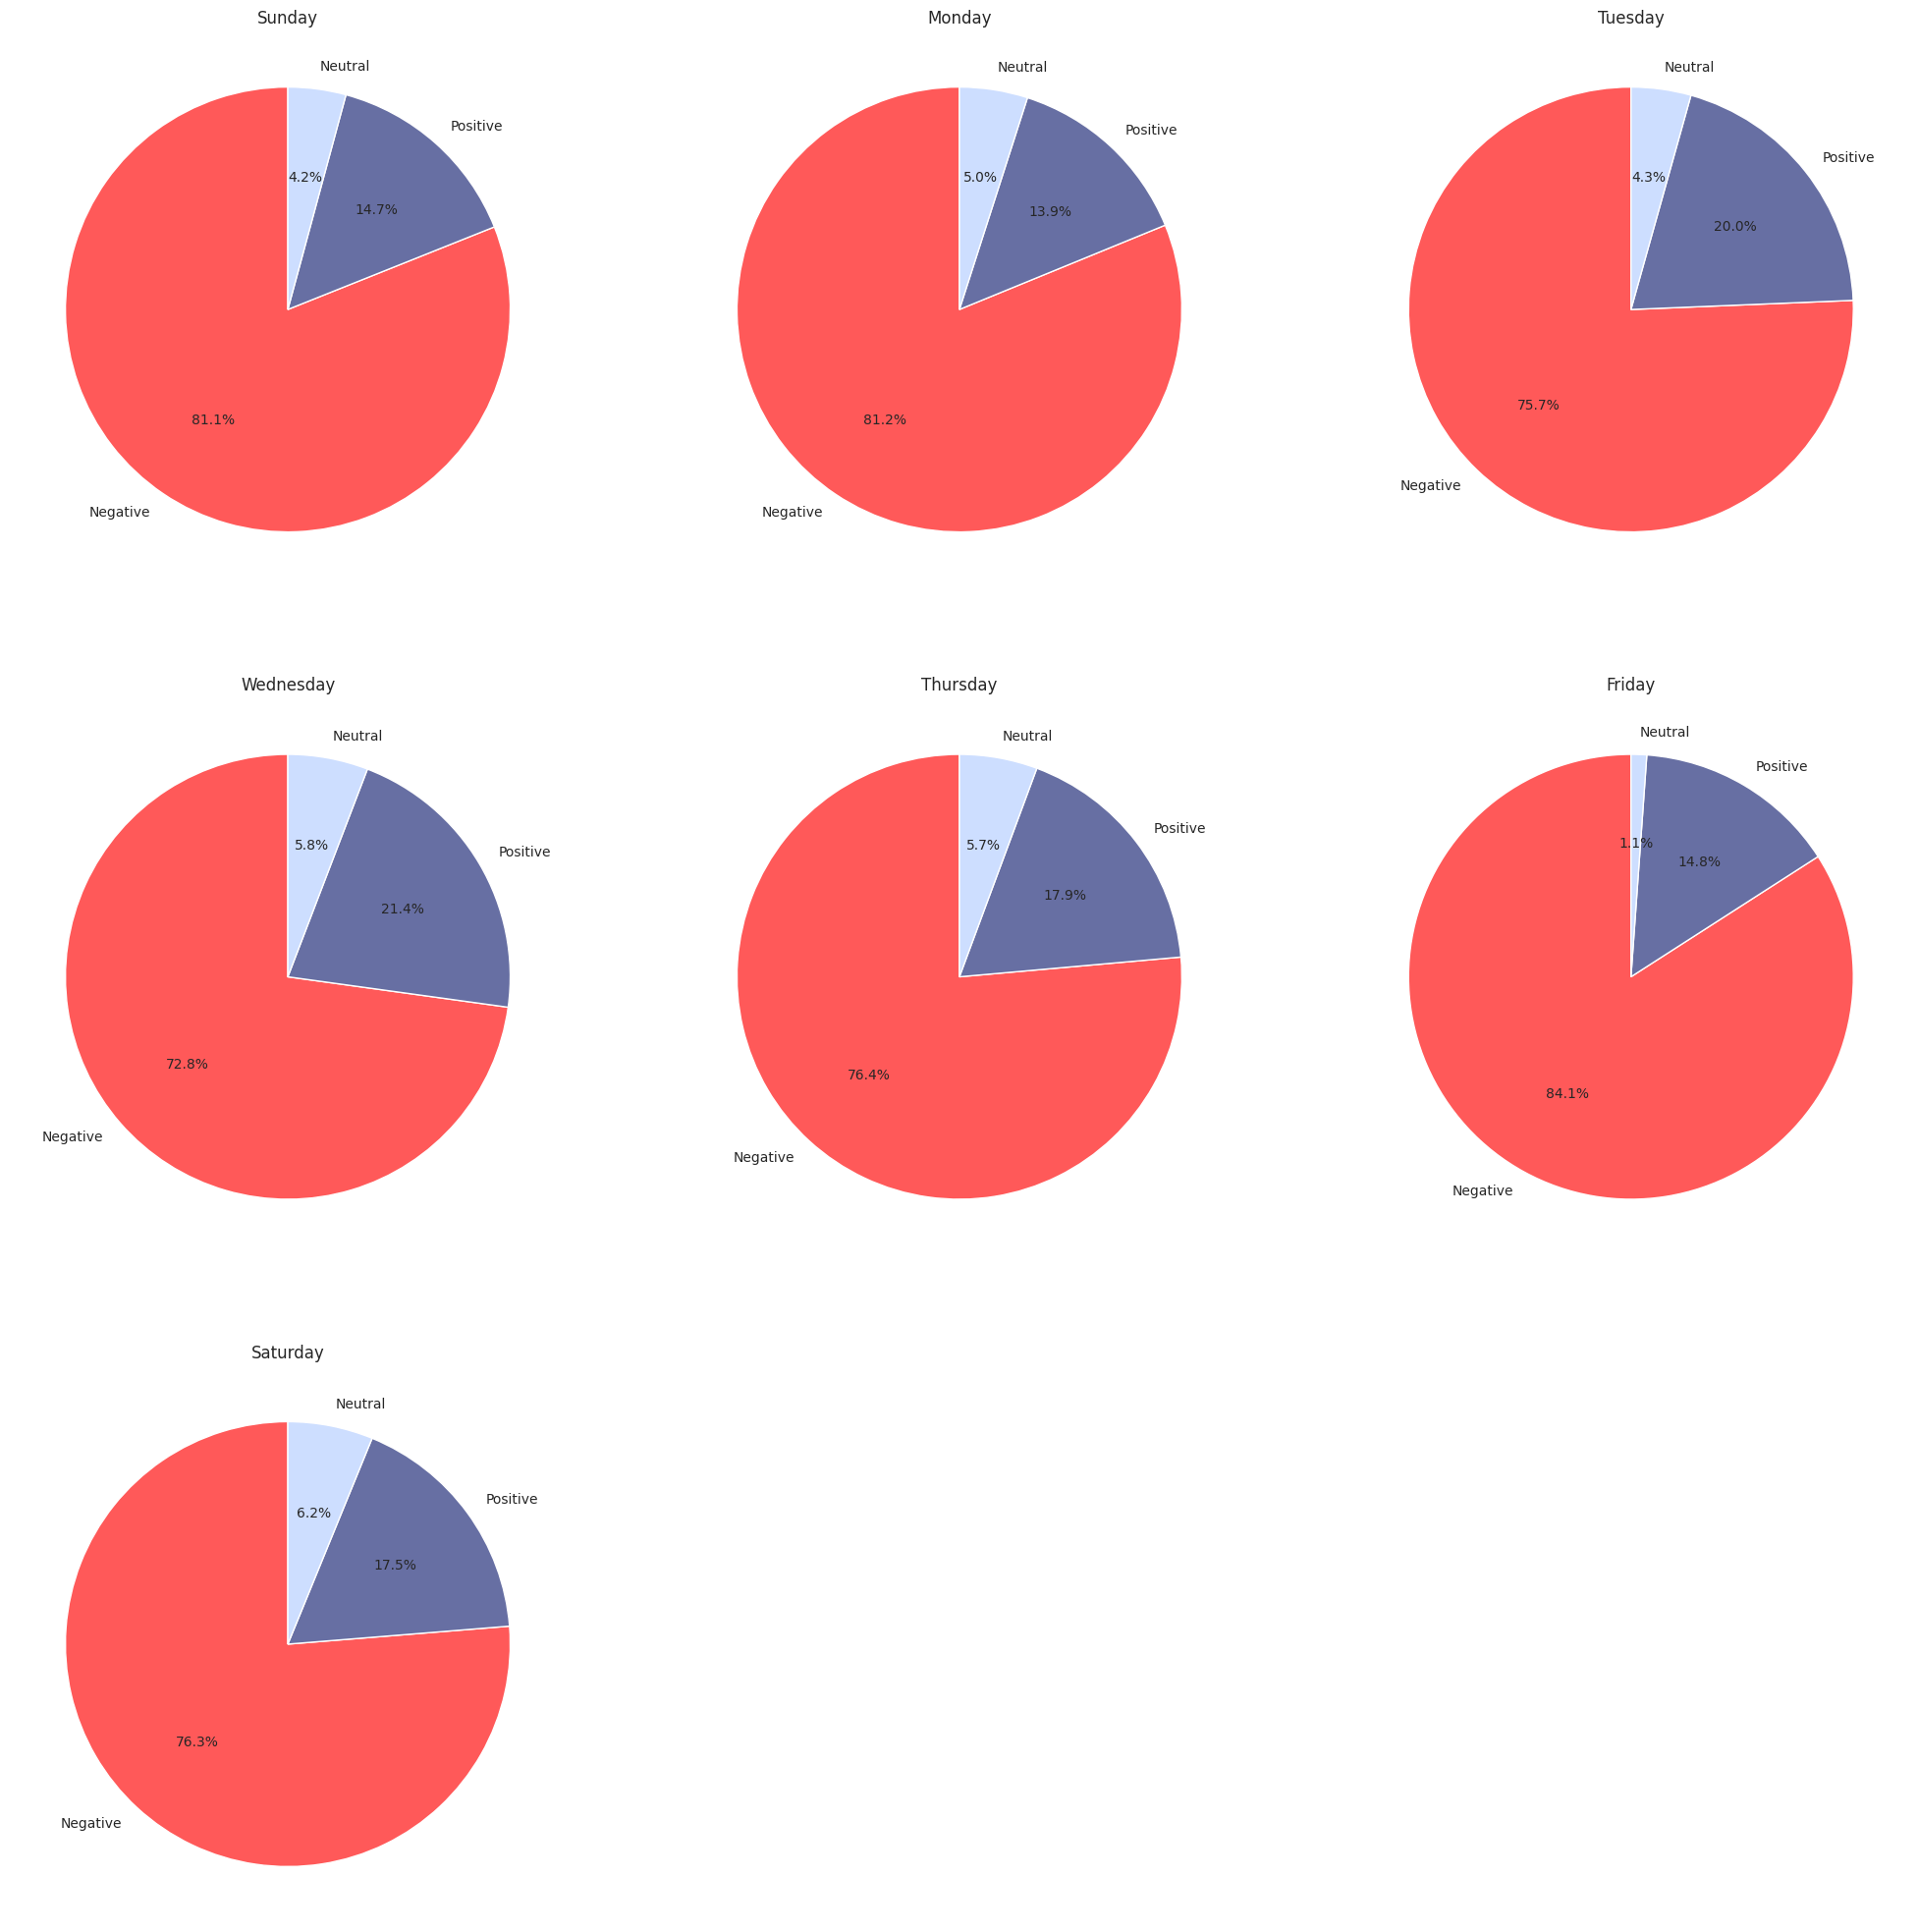

In [23]:
fig = plt.figure(figsize = (25, 25))
i=1
features = df.index
for x in features:
    plt.subplot(3,3, i)
    ax=plt.pie(df.loc[x], labels=df.columns, autopct='%1.1f%%', startangle=90,
        colors=['#FF5959', '#676FA3','#CDDEFF'])
    plt.title(day_order[x], loc='center')
    i+=1
plt.show()

#### Month/Rating

In [24]:
df = data[["Month","Rating"]]
df["Negative"] = df[df["Rating"]==2]["Rating"]
df["Positive"] = df[df["Rating"]==1]["Rating"]
df["Neutral"] = df[df["Rating"]==0]["Rating"]
df.drop("Rating",axis=1,inplace=True)
df=df.groupby("Month").count()

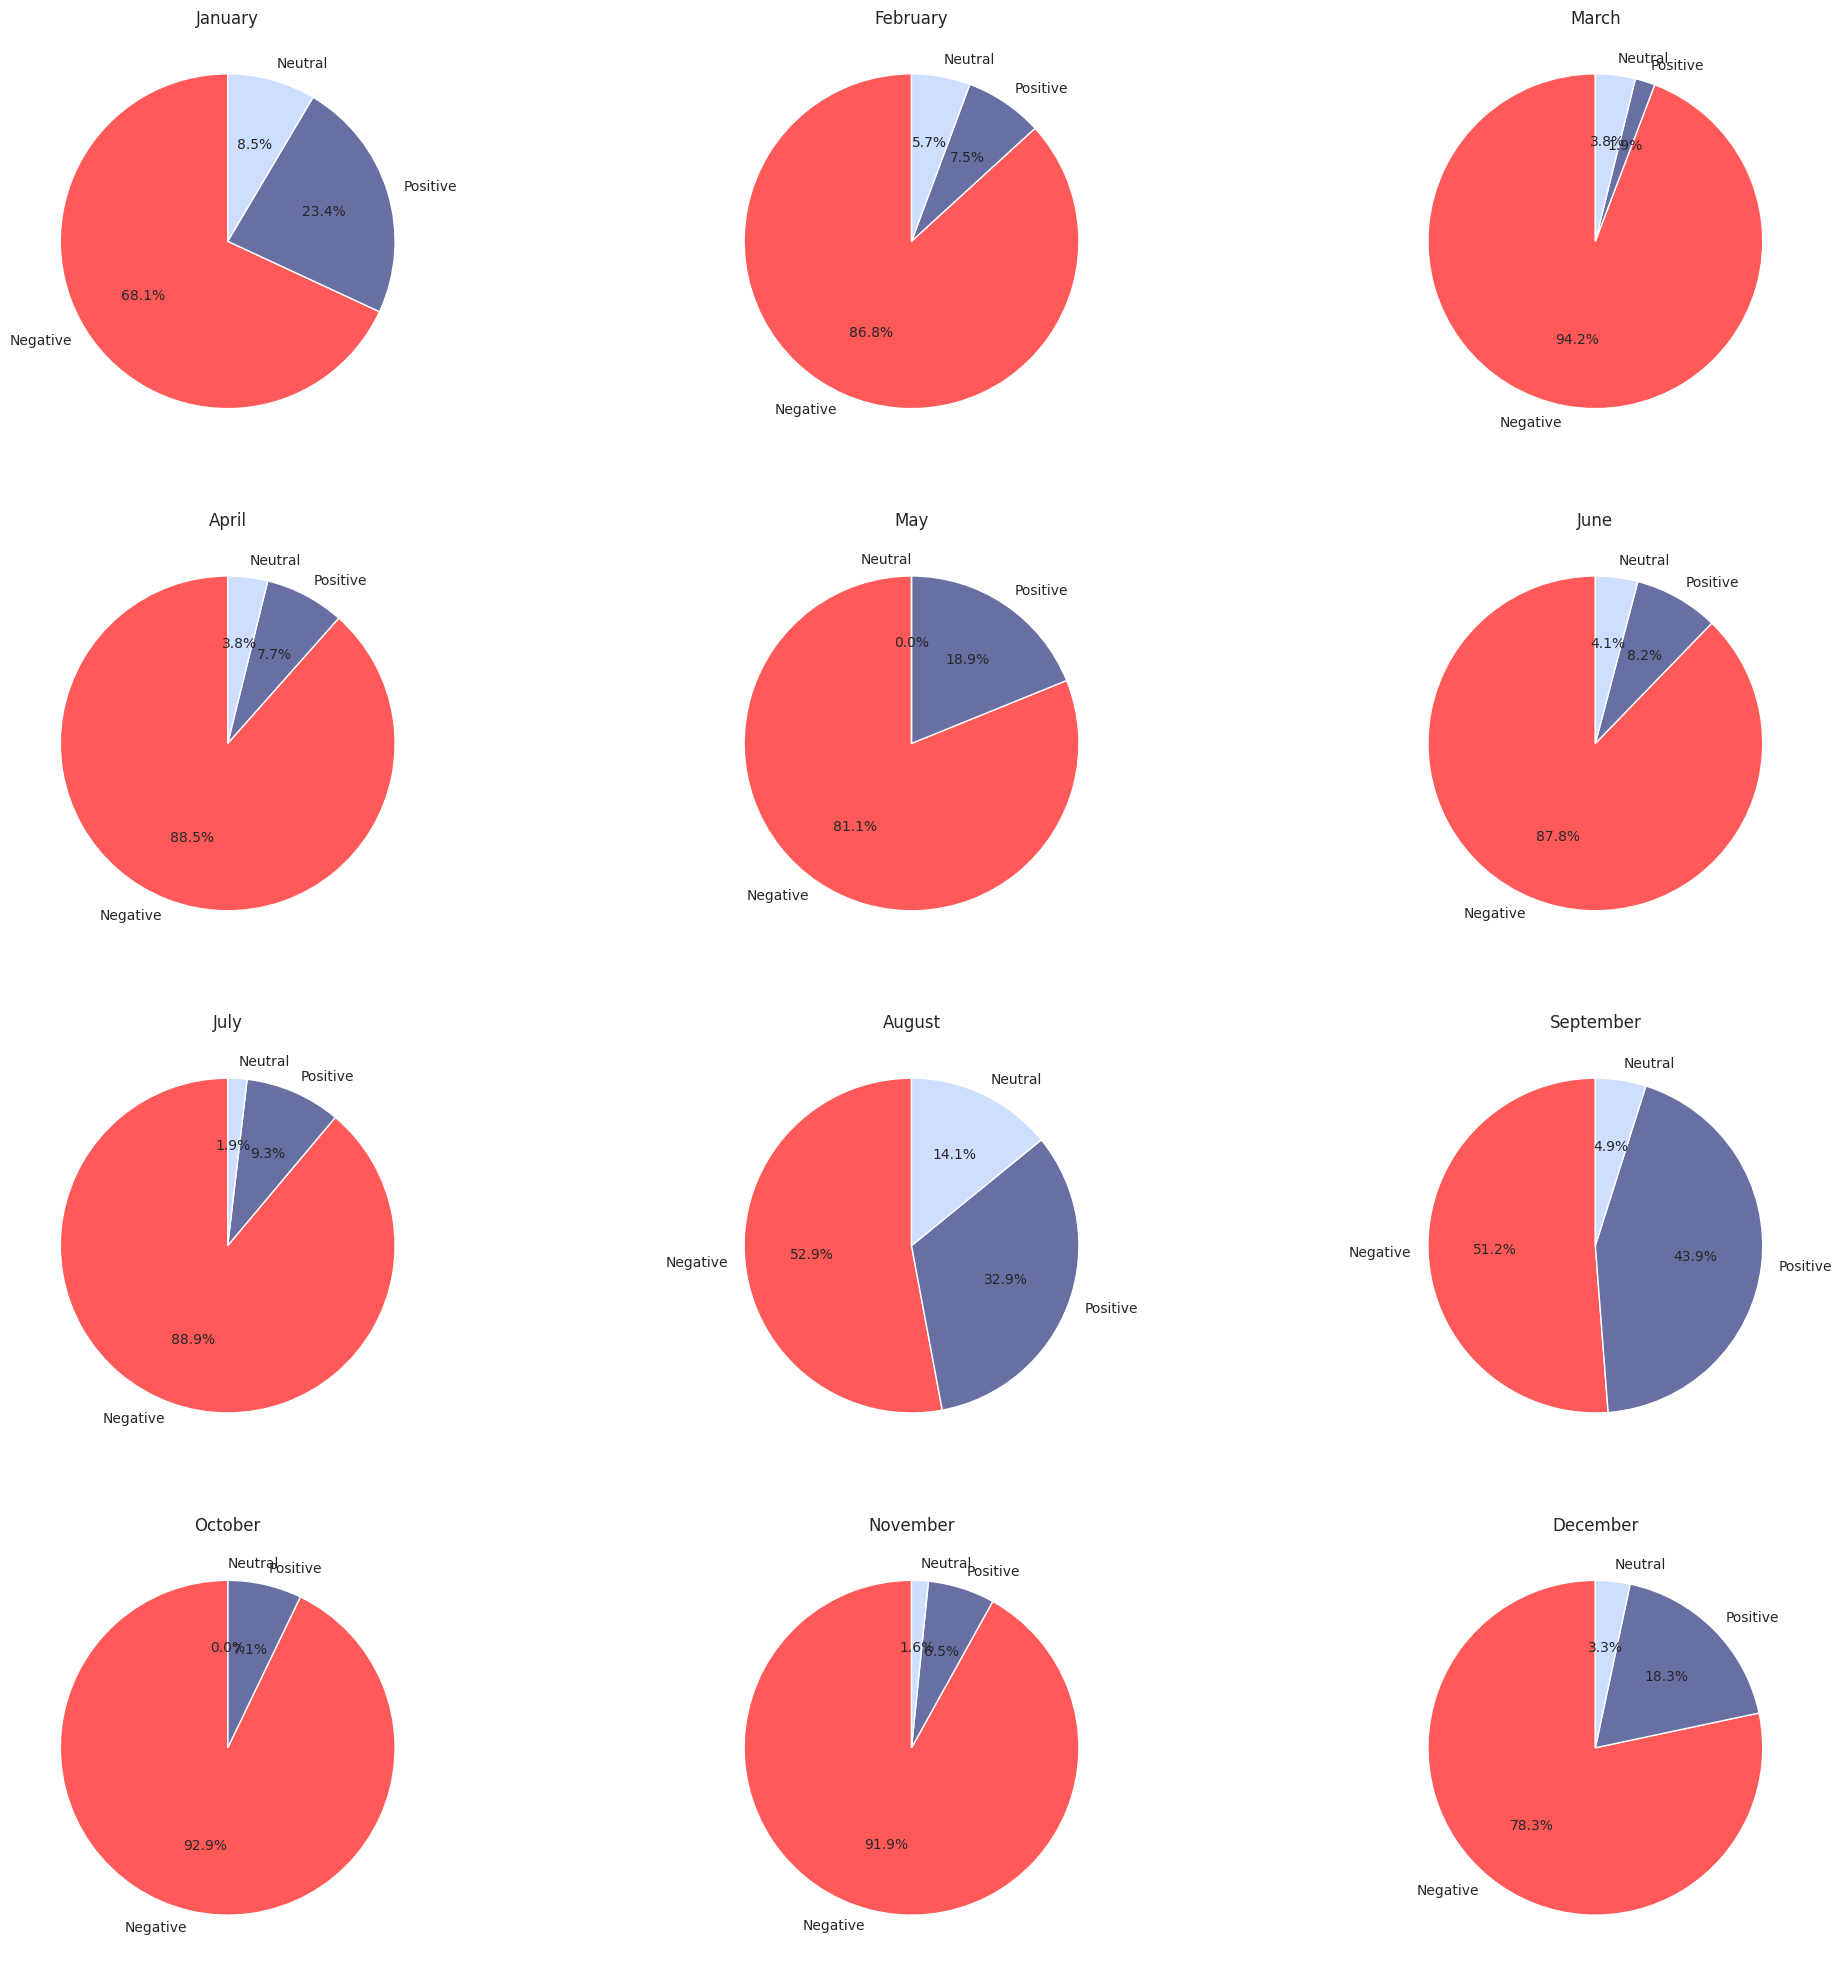

In [25]:
fig = plt.figure(figsize = (25, 25))
i=1
features = df.index
for x in features:
    plt.subplot(4,3, i)
    ax=plt.pie(df.loc[x], labels=df.columns, autopct='%1.1f%%', startangle=90,
        colors=['#FF5959', '#676FA3','#CDDEFF'])
    plt.title(month_order[x-1], loc='center')
    i+=1
plt.show()

#### Year/Rating

In [26]:
df = data[["Year","Rating"]]
df["Negative"] = df[df["Rating"]==2]["Rating"]
df["Positive"] = df[df["Rating"]==1]["Rating"]
df["Neutral"] = df[df["Rating"]==0]["Rating"]
df.drop("Rating",axis=1,inplace=True)
df=df.groupby("Year").count()[1:]

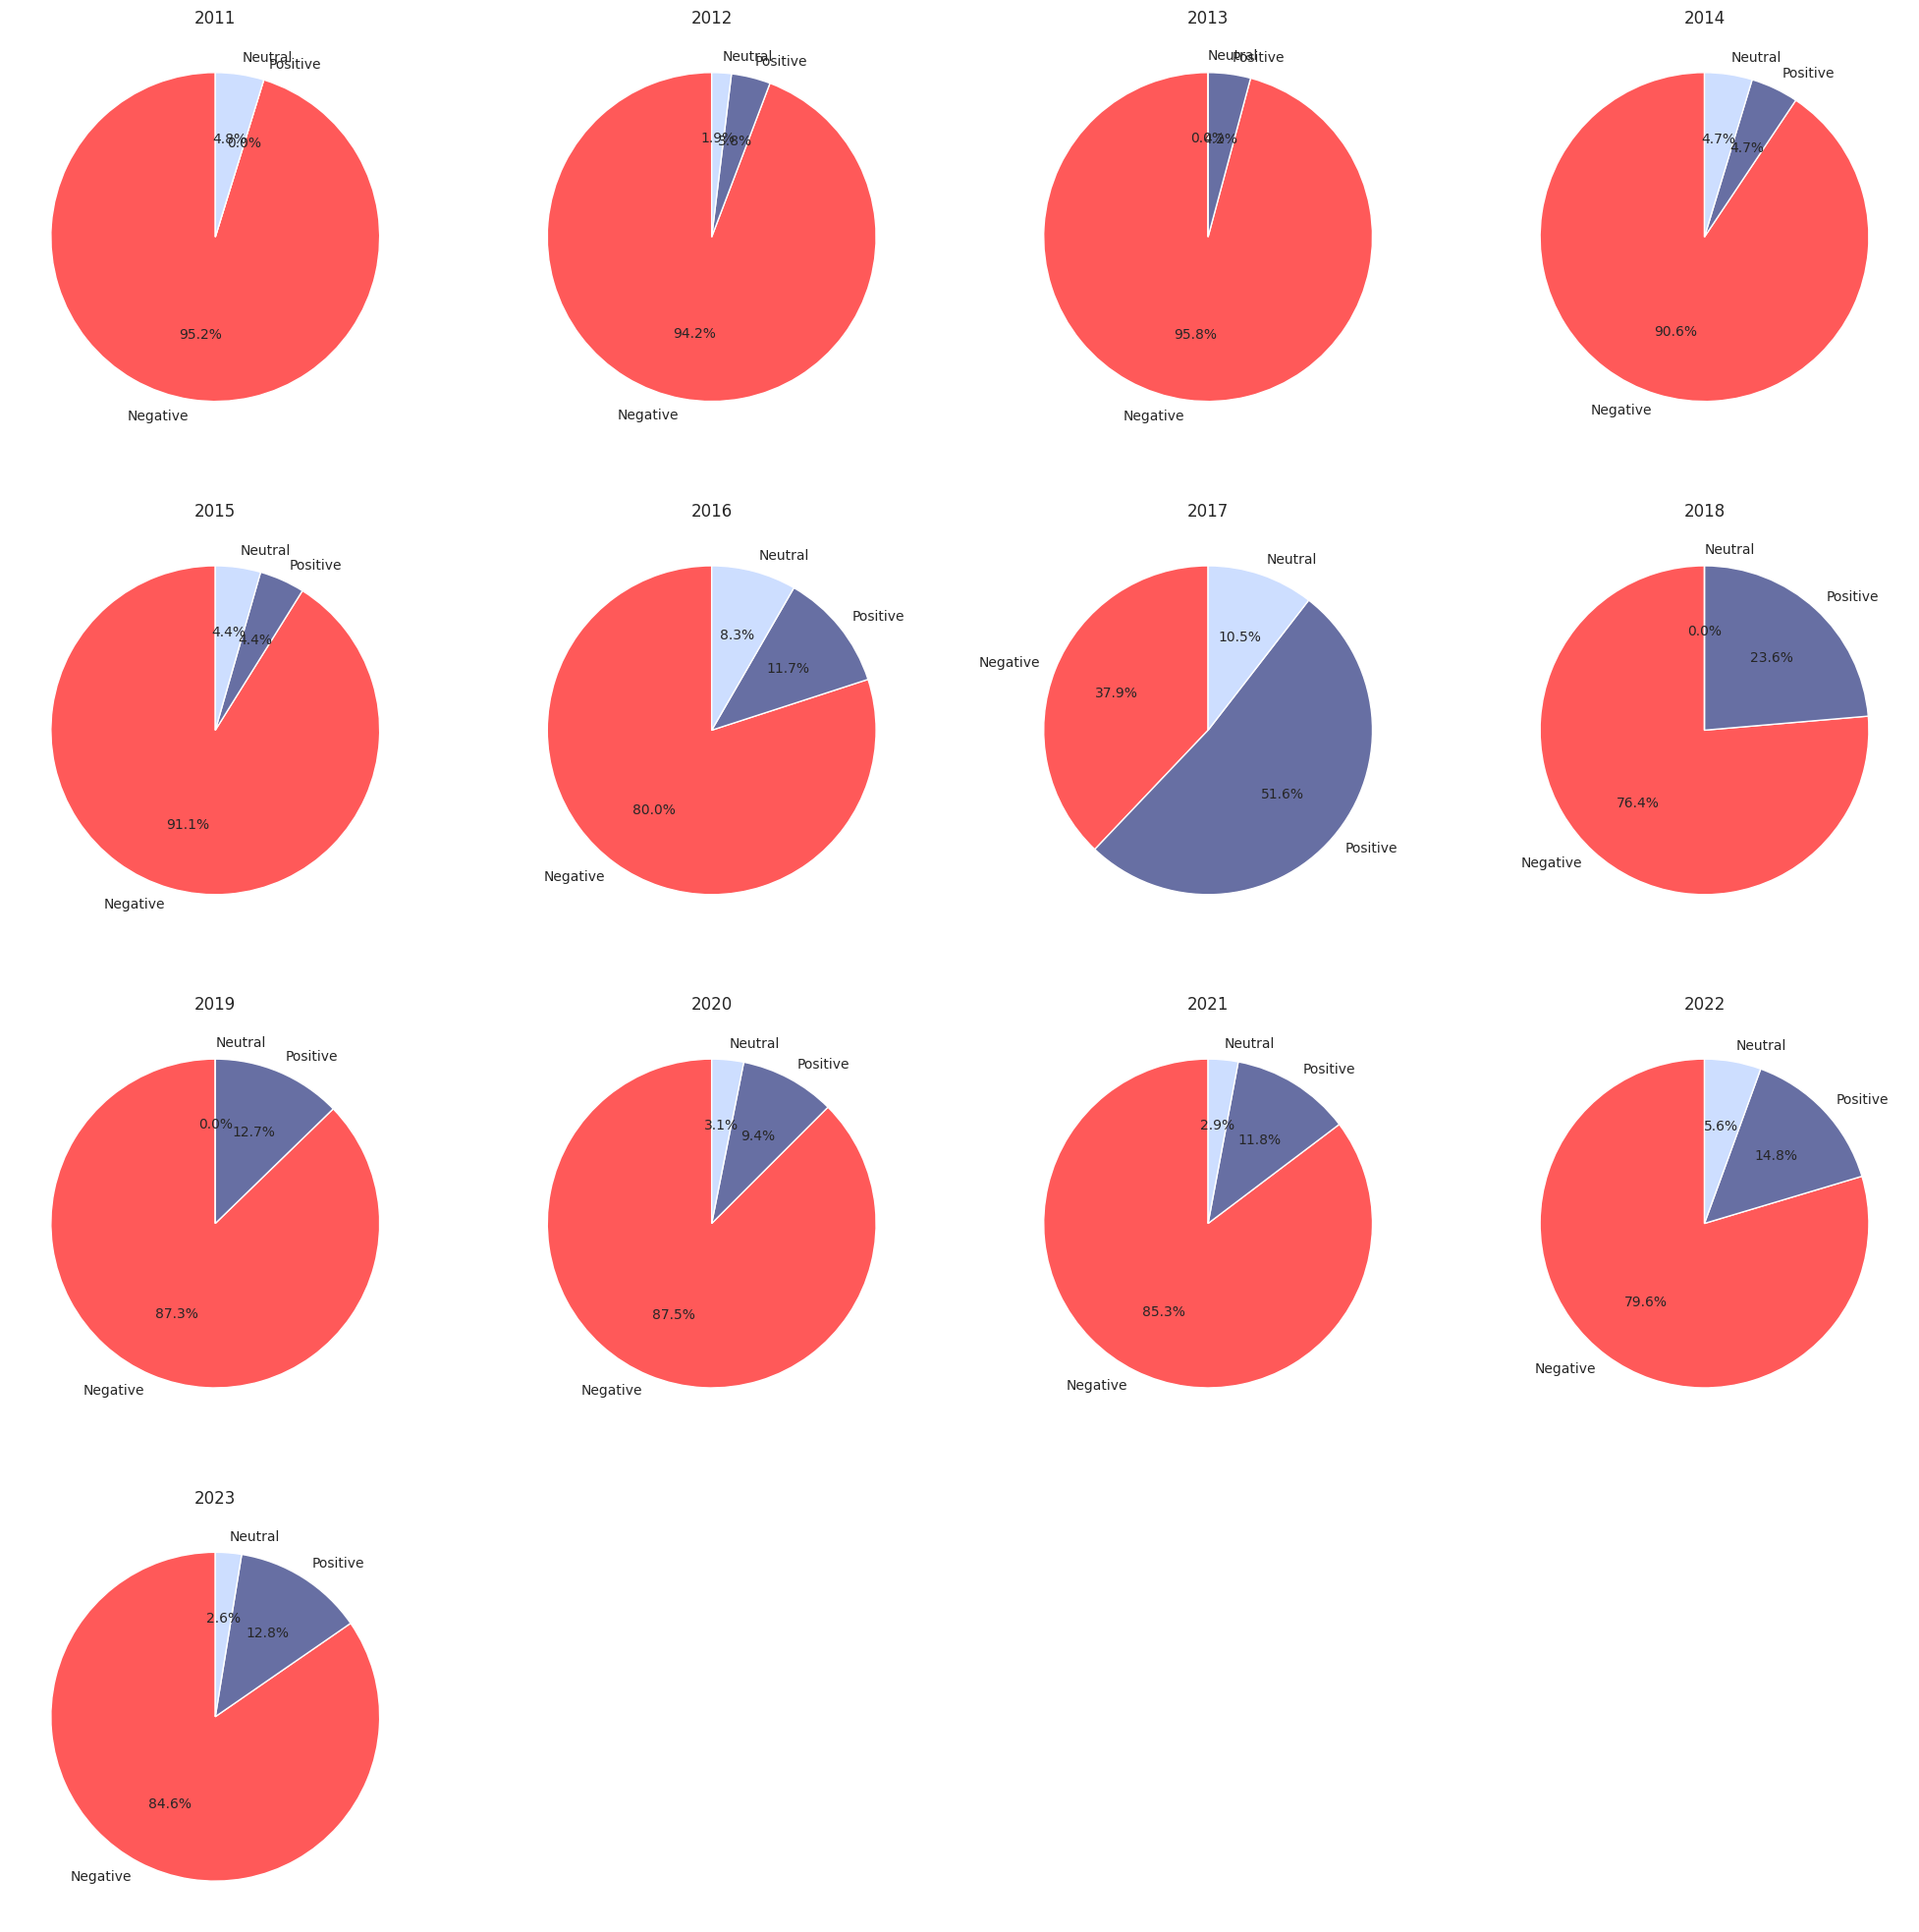

In [27]:
fig = plt.figure(figsize = (25, 25))
i=1
features = df.index
for x in features:
    plt.subplot(4, 4, i)
    ax=plt.pie(df.loc[x], labels=df.columns, autopct='%1.1f%%', startangle=90,
        colors=['#FF5959', '#676FA3','#CDDEFF'])
    plt.title(str(x), loc='center')
    i+=1
plt.show()

It Looks Like All The Year tends to Have mosly negative Reviews expect for the Year 2017 in which for the first time we have a Positive majority of votes! It might be a wise idea to check starbucks history and check for the year 2017 

## Sammary For EDA

After dealing with our EDA we can Notice :

* That our dataset Have mostly Negative Reviews which comes about 78% of the total dataset observations. 
* We can understand that after this analysis that California Have the biggest community of voters about 140 vote in which CA is also the biggest State to have negative Reviews about 80% negative reviews! 
* Date Of the week and Months are Nearly always contains negative reviews however for years : The year 2017 is the only year in our dataset that managed to score a positive rating.


## Cleaning Data

Text data preprocessing plays an initial role within natural language processing (NLP). Its significance rests in the removal of disturbances, inconsistencies, and unnecessary elements from the text. Our method closely follows the steps introduced in the intoduction.

In [28]:
data = data[["Review","Rating"]]

In [29]:
def cleaning (text):
    text = re.sub('[^a-zA-Z]', ' ', str(text).lower().strip())
    text = re.sub('@[A-Za-z0-9_]+', '', text) 
    text = re.sub('#','',text) 
    text = re.sub('RT[\s]+','',text)
    text = re.sub('https?:\/\/\S+', '', text) 
    text = re.sub('\n',' ',text)
    text = emoji.replace_emoji(text, replace='')
    return text

In [30]:
data["Review"]=data["Review"].apply(cleaning)

### Lemmatization

Lemmatization functions as a text preprocessing technique within the domain of natural language processing (NLP) models. Its primary objective is to break down words into their essential roots, making it easier to identify resemblances.

In [31]:
def lemm(data):
    wordnet = WordNetLemmatizer()
    lemmanized = []
    for i in range(len(data)):
        lemmed = []
        words = word_tokenize(data['Review'].iloc[i])
        for w in words:
            lemmed.append(wordnet.lemmatize(w))
        lemmanized.append(lemmed)

    data['lemmanized'] = lemmanized
    data['Review'] = data['lemmanized'].apply(' '.join)
    data=data.drop("lemmanized",axis=1)
    return data
data=lemm(data)

In [32]:
data.head()

,Review,Rating
0,amber and ladonna at the starbucks on southwes...,1
1,at the starbucks by the fire station on in alt...,1
2,i just wanted to go out of my way to recognize...,1
3,me and my friend were at starbucks and my card...,1
4,i m on this kick of drinking cup of warm water...,1


### Splitting Data

In [33]:
labels = data["Rating"]
training = data["Review"]

In [34]:
X_train, X_test, y_train, y_test = train_test_split(training, labels, test_size=0.2, random_state=42)

## Feature Extraction

In [35]:
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

## Training Models

### Logistic Regression 

In [36]:
model= LogisticRegression(multi_class="multinomial")
model.fit(X_train_vec,y_train)
preds =model.predict(X_test_vec)
print(accuracy_score(y_test,preds))

0.8014184397163121


### Decision Tree 

In [37]:
model = DecisionTreeClassifier()
model.fit(X_train_vec,y_train)
preds = model.predict(X_test_vec)
print(accuracy_score(y_test,preds))

0.7375886524822695


### Random Forest

In [38]:
model = RandomForestClassifier()
model.fit(X_train_vec,y_train)
preds = model.predict(X_test_vec)
print(accuracy_score(y_test,preds))

0.7943262411347518


### Support Vector Machine

In [39]:
model = LinearSVC()
model.fit(X_train_vec,y_train)
preds = model.predict(X_test_vec)
print(accuracy_score(y_test,preds))

0.8439716312056738


### Naive bayes

In [40]:
model = MultinomialNB()
model.fit(X_train_vec,y_train)
preds = model.predict(X_test_vec)
print(accuracy_score(y_test,preds))

0.7304964539007093


We got 84% accuracy using SVM which is great because it was been able to perform a multiclass classification with 3 classes!

### CNN

In [41]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_test)


X_train_padded = pad_sequences(X_train_seq, maxlen=100, padding='post')
X_val_padded = pad_sequences(X_val_seq, maxlen=100, padding='post')

In [62]:
model = Sequential([
    Embedding(20001,64,input_length=100,embeddings_regularizer=regularizers.l2(0.0005)),
    Dense(units=128, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(units=3, activation='softmax')
])


model.compile(loss='sparse_categorical_crossentropy', optimizer="Adam", metrics=['accuracy'])

In [43]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 64)           1280064   
                                                                 
 dense (Dense)               (None, 100, 128)          8320      
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 1,288,771
Trainable params: 1,288,771
Non-trainable params: 0
_________________________________________________________________


In [63]:
history = model.fit(X_train_padded, y_train, epochs=15, validation_data=(X_val_padded, y_test))

Epoch 1/15
18/18 [==============================] - 2s 34ms/step - loss: 1.2733 - accuracy: 0.6879 - val_loss: 0.9765 - val_accuracy: 0.7305
Epoch 2/15
18/18 [==============================] - 0s 21ms/step - loss: 0.7608 - accuracy: 0.7926 - val_loss: 0.7723 - val_accuracy: 0.7305
Epoch 3/15
18/18 [==============================] - 0s 22ms/step - loss: 0.6193 - accuracy: 0.7926 - val_loss: 0.7292 - val_accuracy: 0.7305
Epoch 4/15
18/18 [==============================] - 0s 21ms/step - loss: 0.5724 - accuracy: 0.7926 - val_loss: 0.6928 - val_accuracy: 0.7305
Epoch 5/15
18/18 [==============================] - 0s 22ms/step - loss: 0.5341 - accuracy: 0.7926 - val_loss: 0.6584 - val_accuracy: 0.7305
Epoch 6/15
18/18 [==============================] - 0s 23ms/step - loss: 0.4920 - accuracy: 0.7979 - val_loss: 0.6161 - val_accuracy: 0.7376
Epoch 7/15
18/18 [==============================] - 0s 23ms/step - loss: 0.4372 - accuracy: 0.8387 - val_loss: 0.5821 - val_accuracy: 0.7801
Epoch 8/15
18

### Accuracy Variation

In [64]:
evaluation_results = model.evaluate(X_val_padded,y_test)
print("Test Loss:", evaluation_results[0])
print("Test Accuracy:", evaluation_results[1])

5/5 [==============================] - 0s 7ms/step - loss: 0.6364 - accuracy: 0.8440
Test Loss: 0.6363867521286011
Test Accuracy: 0.8439716100692749


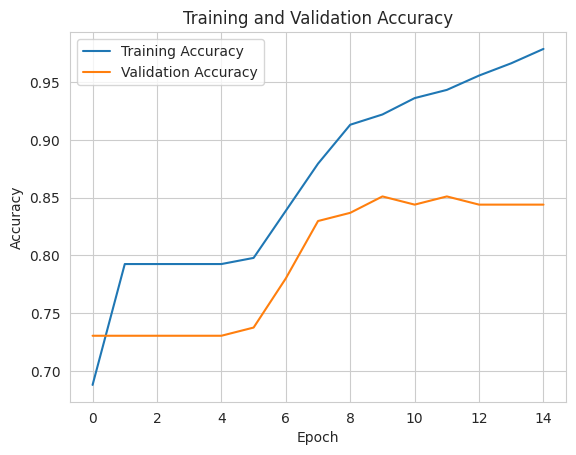

In [65]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

We finally got a 84% accuracy using CNN ! 

### RNN

In [66]:
model = Sequential([
    Embedding(input_dim=20001, output_dim=32, input_length=100, embeddings_regularizer=regularizers.l2(0.0005)),
    LSTM(units=32, return_sequences=True),
    GlobalMaxPooling1D(),
    Dense(units=32, activation='relu'),
    Dense(units=3, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 100, 32)           640032    
                                                                 
 lstm_1 (LSTM)               (None, 100, 32)           8320      
                                                                 
 global_max_pooling1d_7 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_14 (Dense)            (None, 32)                1056      
                                                                 
 dense_15 (Dense)            (None, 3)                 99        
                                                                 
Total params: 649,507
Trainable params: 649,507
Non-trainable params: 0
________________________________________________

In [67]:
history = model.fit(X_train_padded, y_train, epochs=15, validation_data=(X_val_padded, y_test))

Epoch 1/15
18/18 [==============================] - 5s 102ms/step - loss: 1.2295 - accuracy: 0.7500 - val_loss: 1.0950 - val_accuracy: 0.7305
Epoch 2/15
18/18 [==============================] - 1s 70ms/step - loss: 0.8802 - accuracy: 0.7926 - val_loss: 0.7774 - val_accuracy: 0.7305
Epoch 3/15
18/18 [==============================] - 1s 68ms/step - loss: 0.6334 - accuracy: 0.7926 - val_loss: 0.7333 - val_accuracy: 0.7305
Epoch 4/15
18/18 [==============================] - 1s 68ms/step - loss: 0.6147 - accuracy: 0.7926 - val_loss: 0.7313 - val_accuracy: 0.7305
Epoch 5/15
18/18 [==============================] - 1s 62ms/step - loss: 0.6048 - accuracy: 0.7926 - val_loss: 0.7061 - val_accuracy: 0.7305
Epoch 6/15
18/18 [==============================] - 1s 61ms/step - loss: 0.5750 - accuracy: 0.7926 - val_loss: 0.6780 - val_accuracy: 0.7305
Epoch 7/15
18/18 [==============================] - 1s 61ms/step - loss: 0.5152 - accuracy: 0.7926 - val_loss: 0.6709 - val_accuracy: 0.7305
Epoch 8/15
1

In [68]:
evaluation_results = model.evaluate(X_val_padded,y_test)
print("Test Loss:", evaluation_results[0])
print("Test Accuracy:", evaluation_results[1])

5/5 [==============================] - 0s 15ms/step - loss: 0.6428 - accuracy: 0.8369
Test Loss: 0.6428341269493103
Test Accuracy: 0.8368794322013855


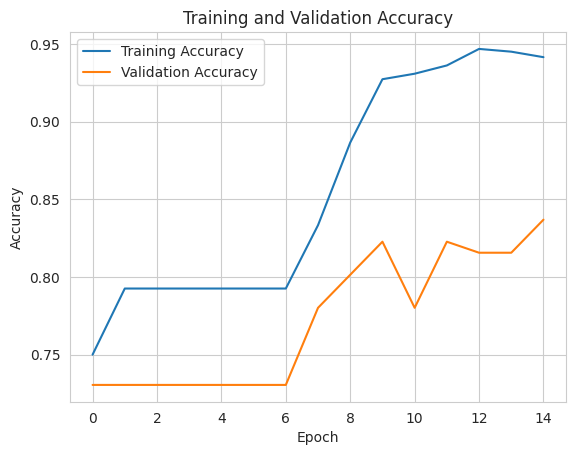

In [69]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()